# Feature Engineering


In [1]:
random_state = 42

In [2]:
import sys
import os
import time
import glob
from pathlib import Path
import sklearn
import pandas as pd
import numpy as np
from collections import Counter


import matplotlib.pyplot as plt
import seaborn as sns


IN_COLAB = 'google.colab' in sys.modules

if(IN_COLAB):
    !git clone https://github.com/berni-lehner/structural_health_monitoring.git
    sys.path.insert(0,"/content/structural_health_monitoring/src")
    sys.path.insert(0,"/content/structural_health_monitoring/data")    
else:
    sys.path.insert(0,"../src")
    sys.path.insert(0,"../data")
    


try:
    from zippeekiyay import namelist
except ImportError or ModuleNotFoundError:
    print('installing zippee-ki-yay...')
    !pip install git+https://github.com/berni-lehner/zippee-ki-yay.git

    from zippeekiyay import namelist

In [3]:
from DataDownloader import DataDownloader as ddl
from data_utils import load_processed_data, FEATURE_LIST
from manifold_utils import tsne_embedding
from LogFilterbank import LogFilterbank
from plot_utils import plot_embedding_targets, init_plotting

# configure fonts, etc...
init_plotting()

In [4]:
url = r"https://sandbox.zenodo.org/record/1115172/files/data_synthetic.zip"
DATA_PATH = Path(r"../data/synthetic/")


start_time = time.perf_counter()
dl_succeed = ddl.download_and_unpack(url, DATA_PATH, cache=True)
end_time = time.perf_counter()
print(f"time passed: {end_time-start_time:.2f} s")
print(f"downloading successful: {dl_succeed}")

time passed: 6.05 s
downloading successful: True


In [5]:
# configuration
sr = 120000 #originally from df['kHz'].iloc[-1]*1000*2 # from measurement, highest f[kHz]*2
n_log_bins = 87
n_fft = 1600
n_fft_bins = 801
f_min = 1300
norm = 'height'

fb = LogFilterbank(sr=sr, n_fft_bins=n_fft_bins, n_log_bins=n_log_bins, f_min=f_min, norm=norm)

In [6]:

#plt.rcParams.keys()

In [7]:
import glob

to_dB = True

PATH = r"..\data\synthetic"

DATA_PATH = Path(r"../data/synthetic/")

from pathlib import Path
file_names = list(DATA_PATH.glob('**/*.csv'))

# cache file for faster data loading on later iterations
pickle_name = Path(DATA_PATH, f"filtered_specs__fmin_{fb.f_min}__fmax_{fb.f_max}__lbins_{fb.n_log_bins}.pkl")
pickle_name

WindowsPath('../data/synthetic/filtered_specs__fmin_1300__fmax_60000.0__lbins_87.pkl')

In [8]:
%%time
df = load_processed_data(file_names, fb, y_col=[FEATURE_LIST[0], FEATURE_LIST[1]], to_dB=to_dB, cache_file=pickle_name)

#filtered_df.head()

CPU times: total: 266 ms
Wall time: 266 ms


In [9]:
#filtered_df.info()

In [10]:
X = df[df.columns[0:fb.n_log_bins]].values

In [11]:
X.shape

(34152, 87)

In [12]:
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

scaler = StandardScaler()
scaler.fit(X)

X = scaler.transform(X)

df[df.columns[0:fb.n_log_bins]] = X


In [13]:
plot_df = df.drop(columns=['y_cat', 'file'])

In [14]:
plot_df.columns

Index(['logspec_0', 'logspec_1', 'logspec_2', 'logspec_3', 'logspec_4',
       'logspec_5', 'logspec_6', 'logspec_7', 'logspec_8', 'logspec_9',
       'logspec_10', 'logspec_11', 'logspec_12', 'logspec_13', 'logspec_14',
       'logspec_15', 'logspec_16', 'logspec_17', 'logspec_18', 'logspec_19',
       'logspec_20', 'logspec_21', 'logspec_22', 'logspec_23', 'logspec_24',
       'logspec_25', 'logspec_26', 'logspec_27', 'logspec_28', 'logspec_29',
       'logspec_30', 'logspec_31', 'logspec_32', 'logspec_33', 'logspec_34',
       'logspec_35', 'logspec_36', 'logspec_37', 'logspec_38', 'logspec_39',
       'logspec_40', 'logspec_41', 'logspec_42', 'logspec_43', 'logspec_44',
       'logspec_45', 'logspec_46', 'logspec_47', 'logspec_48', 'logspec_49',
       'logspec_50', 'logspec_51', 'logspec_52', 'logspec_53', 'logspec_54',
       'logspec_55', 'logspec_56', 'logspec_57', 'logspec_58', 'logspec_59',
       'logspec_60', 'logspec_61', 'logspec_62', 'logspec_63', 'logspec_64',
       'l

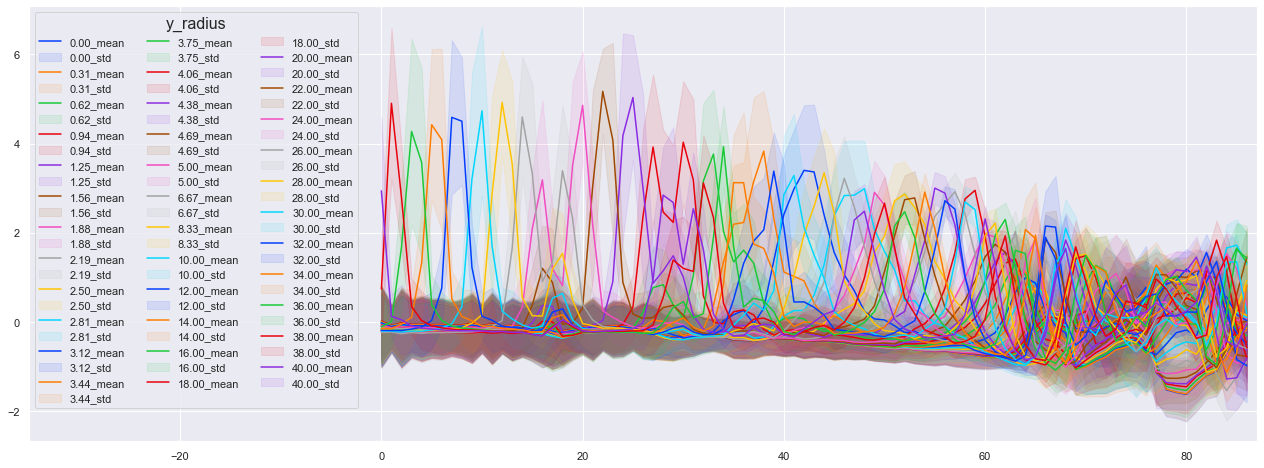

In [15]:
from plot_utils import plot_classwise_dist, plot_classwise_kde

fig = plot_classwise_dist(df=plot_df, label_col='y_radius')
fig.set(xlim=(-35, len(plot_df.columns)-1)); 

In [16]:
import itertools
import ipywidgets as widgets

label_col = 'y_radius'

cntr = Counter(plot_df[label_col])
labels = list(cntr.keys())
palette = sns.color_palette("bright", len(cntr.keys()))

# we want a legend with formatted strings
legend_entries = [f"{item:.2f}" for item in list(cntr.keys())]



 
feature_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(plot_df.columns)-2,
    step=1,
    description='feature:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=widgets.Layout(width='100%')
)


focus_slider = widgets.IntSlider(
    value=-1,
    min=-1,
    max=len(cntr.keys())-1,
    step=1,
    description='target focus:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=widgets.Layout(width='100%')
)


fig = widgets.interact(plot_classwise_kde,
                 df=widgets.fixed(plot_df),
                 label_col=widgets.fixed(label_col),
                 labels=widgets.fixed(labels),
                 palette=widgets.fixed(palette),
                 legend_entries=widgets.fixed(legend_entries),
                 feature_idx=feature_slider,
                 focus=focus_slider);

dir(fig)

interactive(children=(IntSlider(value=0, continuous_update=False, description='feature:', layout=Layout(width=…

['__annotations__',
 '__call__',
 '__class__',
 '__closure__',
 '__code__',
 '__defaults__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__globals__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__kwdefaults__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'widget']

In [18]:
X_embedded = tsne_embedding(X=X, perplexity=50)

X_embedded.shape

(34152, 2)

In [19]:
df_embedded = pd.DataFrame(X_embedded, columns=['x', 'y'])
df_embedded[label_col] = df[label_col]

df_embedded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34152 entries, 0 to 34151
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   x         34152 non-null  float32
 1   y         34152 non-null  float32
 2   y_radius  34152 non-null  float32
dtypes: float32(3)
memory usage: 400.3 KB


In [20]:
# predefine palette to keep it from changing after thresholding changes the number of classes to be mapped, hence ever changing the palette
palette = dict(zip(cntr.keys(), sns.color_palette(palette="bright", n_colors=len(cntr.keys()))))
palette.update({-1: "k"})

In [21]:
import ipywidgets as widgets


df, label_col, labels, palette, legend_entries
def embedding_widget(df, label_col, thresh=0., palette=palette):
    y = np.copy(df[label_col].values)
    y[y<thresh] = -1
        
    X = df.drop(columns=[label_col]).values
    
    plot_embedding_targets(X, y, alpha=0.2, palette=palette)
    plt.title("X", size=32)


thresh_slider = widgets.FloatSlider(
    value=0.,
    min=0.0,
    max=40,
    step=0.01,
    description='thresh:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
    layout=widgets.Layout(width='90%')
)

widgets.interact(embedding_widget,
                 df=widgets.fixed(df_embedded),
                 label_col=widgets.fixed(label_col),
                 thresh=thresh_slider,
                 palette=widgets.fixed(palette));

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='thresh:', layout=Layout(wid…